In [133]:
import ira
from tqdm.auto import tqdm
import statsmodels.api as sm
import json
%alphalab dark

from alpha.utils.stat_helpers import cmp_to_norm
import seaborn as sns
import qlearn as q

from utils import load_ohlc, norm, ksmooth, merge_columns_by_op
from algo import PairsPreparation, PairsStrategy

from scipy.stats import normaltest
from ira.utils.ui_utils import green, red

def test_normal(xs, alpha=0.05):
    if normaltest(xs).pvalue < alpha:
        print(red(">> Reject null hyphothesis that series comes from a normal distribution"))
    else:
        print(green(">> Can't reject null hyphothesis that series comes from a normal distribution"))

<hr/>

# Load data from previous step
<hr/>

In [2]:
with open('coint_pairs_5Min.json', 'r') as f:
    coint_pairs = json.load(f)
    
end_of_train = pd.Timestamp(coint_pairs['end'])

In [3]:
pd.DataFrame.from_dict(coint_pairs)

,pairs,start,end,timeframe
"ALPHAUSDT,ALGOUSDT",5.875312e-04,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"AMPLUSDT,ADAUSDT",5.812344e-03,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"AMPLUSDT,ALGOUSDT",3.707732e-02,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"AMPLUSDT,ALPHAUSDT",2.528838e-02,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"AVAXUSDT,ALGOUSDT",2.075339e-03,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
...,...,...,...,...
"ZRXUSDT,STXUSDT",8.735175e-03,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"ZRXUSDT,UNISWAPUSDT",4.382770e-02,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"ZRXUSDT,USDTUSDT",1.453394e-05,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min
"ZRXUSDT,XEMUSDT",2.051342e-07,2022-06-01 00:00:00,2022-06-26 12:00:00,5Min


In [182]:
md = load_ohlc('1Min', '2022-06-01', '2022-07-05')
F = '15Min'
closes = retain_columns_and_join(ohlc_resample(md, F), 'close').ffill()

<hr/>

# Methodology of spread creating
<hr/>

Now we are going to run simple trading model on co-integrated pairs found on previous step.

For example if X and Y price series are co-integrated we can try to estimate linear regression in form
$$ \hat Y_t = \beta \cdot X_t + \varepsilon $$

where $\hat Y_t$ - estimated price of Y and $\varepsilon \sim N(0,1)$. 
Then spread between observed and estimated Y is $S_t = Y_t - \hat Y_t$. There are some ways for estimate linear regression coefficient $\beta$:

    - ordinary least squares (OLS) using train period data
    - OLS on rolling basis (use most recent data on rolling basis)
    - Kalman FIlter (requires only estimations for covariance of observed and hidden variable)

We will apply Kalman filter for estimating regression parameter beta here as it doesn't involve guessing about the rolling periods etc.

Let's look at spread ($\hat Y - Y$) generated for the first co-integrated pair:

In [110]:
pt = PairsPreparation(closes, end_of_train)

In [111]:
test1 = pt.get_trader('ALPHAUSDT', 'ALGOUSDT')

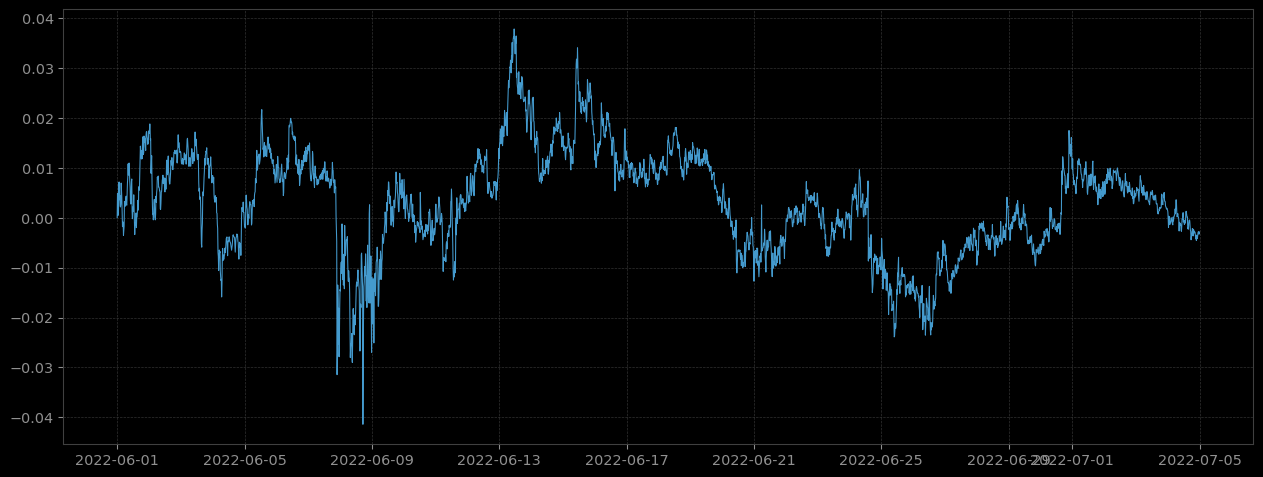

In [112]:
fig(16, 6)
plt.plot(test1.data.spread)

If we look at spread distribution we can see that it looks like sampled from normal distribution:

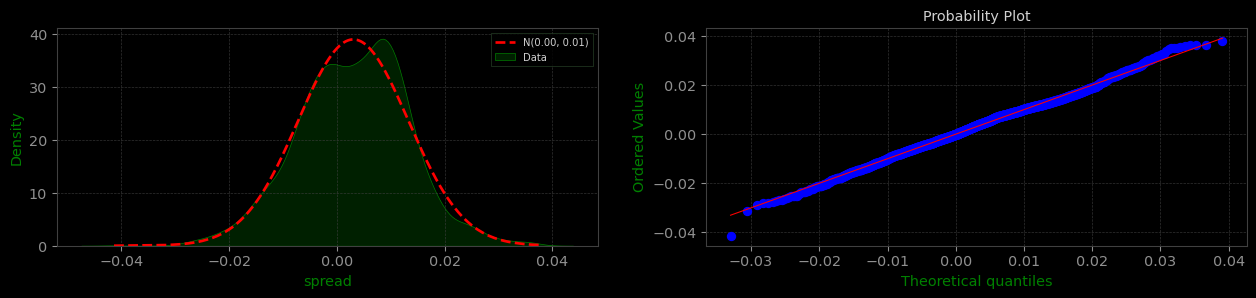

In [134]:
fig(16, 3); cmp_to_norm(test1.data.spread)

Bit normality test says us that statistically it may be not true with 5% confidence interval

In [135]:
test_normal(test1.data.spread, 0.05)

>> Reject null hyphothesis that series comes from a normal distribution


We can try to transform our spread to normal distribution (z-score) by applying: 
    $$Z_t = \frac{S_t - \bar S_t}{\sigma(S_t)}$$
where $\bar S_t \text{ and } \sigma(S_t)$ - mean value and standard deviation of $S_t$

In [137]:
zscr = test1.zscore(test1.data.spread, test1.period)

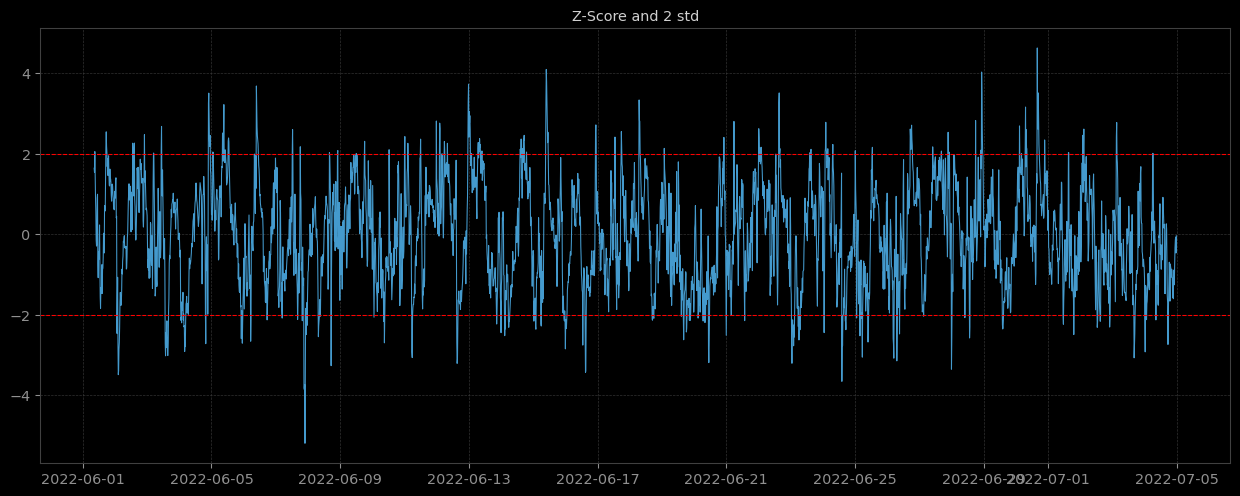

In [138]:
fig(16, 6)
plt.plot(zscr); plt.axhline(2, ls='--', c='r'); plt.axhline(-2, ls='--', c='r'); plt.title("Z-Score and 2 std");

Now it passes normality tests with 5% confidence:

In [139]:
test_normal(zscr, 0.05)

>> Can't reject null hyphothesis that series comes from a normal distribution


Now we can try to test this spread for tradeability. 

So after z-score exceeds +/- 2 standard deviations we'd expect that it will back towards  it's mean value (zero for z-score) in future and can make entry:

    - if Z > +2 we sell the spread (as S = X - b * Y, selling means buy 1 usd of X leg and sell b usd of Y leg)  
    - if Z < -2 we buy the spread (sell 1 usd of X leg and buy b usd of Y leg)  
    - when Z back to 0 we close both positions (we can use not 0 as exit but wait until spread crosses 0 and hits let's say 1 std on opposite side)

Let's run simulation for spread we were exploring above using 1 USD as investment (actually it's 1 usd for leg X  + b USD for Y).

We will use market orders for simplicity and Binance VIP0 commissions (worst case for regular user: 0.04% for market order)

In [151]:
signals = test1.get_signals(
    2, # enter on +2/-2 z score 
    1  # exit on -1/1 z score (opposite side)
)

Here how signals look for this pair: at 1-jun 9:29:59 we bought ALPHA on 2.48 USD and at same time sold ALGO. 
Position was closed in almost 2 hours.

In [154]:
signals.dropna().head()

,ALPHAUSDT,ALGOUSDT
time,,
2022-06-01 09:29:59,2.486164,-1.0
2022-06-01 11:44:59,0.000000,0.0
2022-06-01 18:29:59,2.487248,-1.0
2022-06-02 01:44:59,0.000000,0.0
2022-06-02 01:59:59,-2.492004,1.0


Let's show some first trades on spread chart

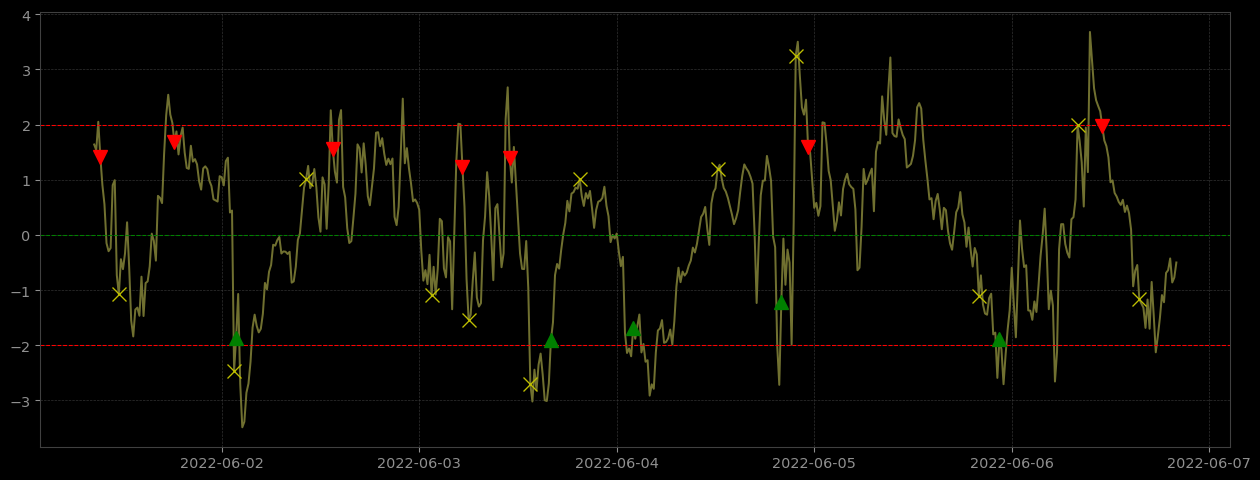

In [257]:
dT = slice('2022-06-01 8:00', '2022-06-06 20:00') 
fig(16, 6)
plt.plot(zscr[dT], lw=1.5, c='#707030')
plt.axhline(+2, ls='--', c='r'); plt.axhline(-2, ls='--', c='r'); plt.axhline(0, ls='--', c='g')
s0 = signals.dropna()[dT]
for t0, t1 in zip(s0.index[::2], s0.index[1::2]):
    side = s0.loc[t0][1]
    plt.plot(t0.floor(F), zscr[t0.floor(F)], 'rv' if side < 0 else 'g^' , ms=10)
    plt.plot(t1.floor(F), zscr[t1.floor(F)], 'yx', ms=10)

Run simulation for this sigals

In [152]:
r0 = q.simulation({'Test0': signals}, md, 'binance_um_vip0')

2022-07-20 14:40:57,932 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2022-07-04 23:59:48.001000]


 0: /Test0  : Sharpe: 5.16 | Sortino: 17.41 | CAGR: 45042.00 | DD: $0.38 (17.56%) | Gain: $1.28 | Execs: 310 | Comm: 0.23[inc][OK]


,Name,sharpe,sortino,cagr,dd,dd_pct,gain,number_executions,comm
0,/Test0,5.159493,17.409566,45042.001871,0.378738,17.558418,1.28117,310,0.227497


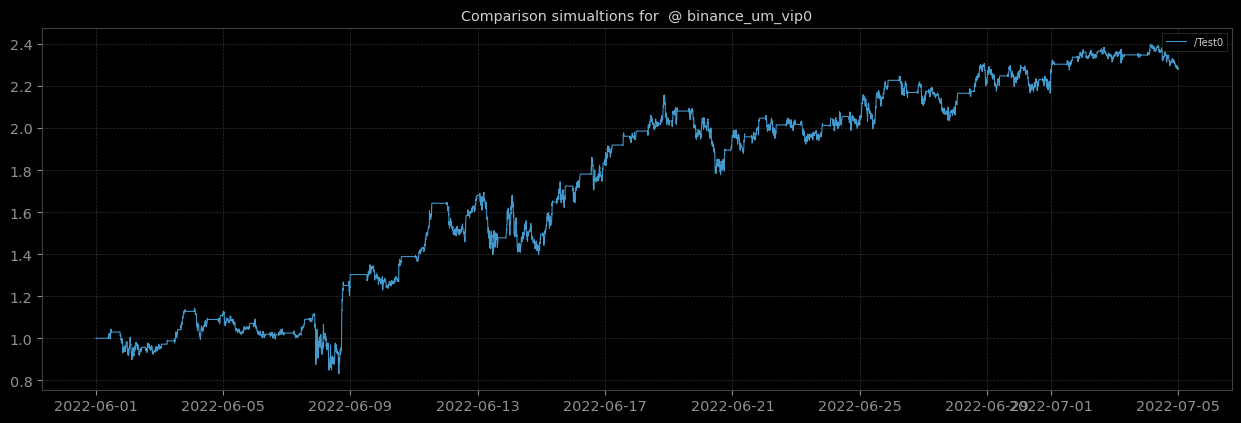

In [142]:
fig(16, 5)
r0.report(1)

And more detailed statistics


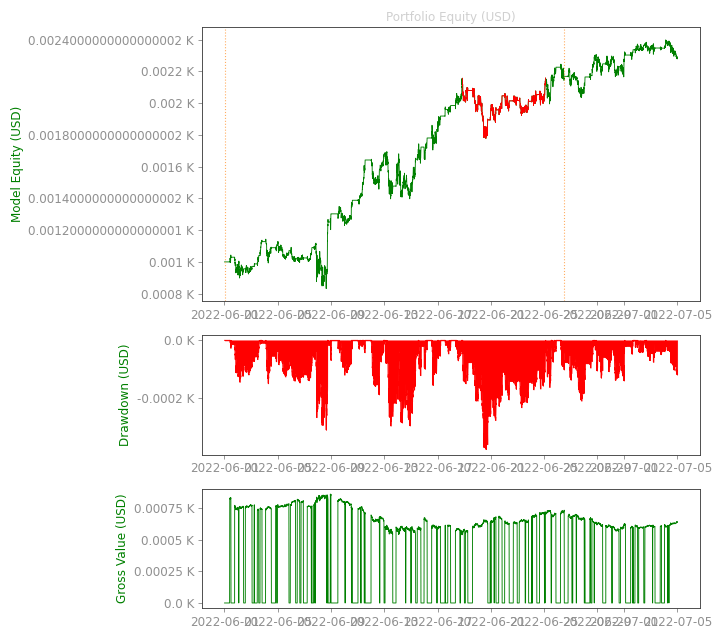

<Figure size 720x640 with 0 Axes>

In [147]:
tearsheet(r0.results[0], 1, insample=str(end_of_train));

As we can see this pair generated stable equity with Sharpe ratio > 5. 

Also we can see that equity continues it's rising trend after end_of_train period (yellow vertical line)

<hr/>

## Run simulation for all pairs

<hr/>

Now we can apply this approach on all co-integrated pairs we found on previous step. It's clear that not all combinations will be tradeable therefore we will select only ones that generated Shrpe > 1 on in-sample period and run this selected portfolio on out-of-sample to see if this approach generates any profitable porftolio.

So steps to do:

    - for each pair run simulation in-sample
    - if sharpe > 1 we add this pair to selected portfolio
    - run selected pairs out-of-sample period
   
Some markets may have many counterparts so we also take it in account in merge_columns_by_op method. 

In [ ]:
pt = PairsPreparation(closes, end_of_train)

c_sigs = None
rrs = []

# - for all found pairs on in-sample period
for k in coint_pairs['pairs'].keys():
    s1, s2 = k.split(',')
    sigs0 = pt.get_trader(s1, s2).get_signals(2, 1)
    r = q.simulation({f'{s1} | {s2}': sigs0[:end_of_train]}, md, 'binance_um_vip0_usdt')
    
    # we select pairs that performed well on train (insample) period 
    # and store signals for out-of-sample tests 
    if r.results[0].performance(1, account_transactions=True).sharpe > 1:
        c_sigs = merge_columns_by_op(c_sigs, sigs0, lambda x,y: x.add(y, fill_value=0))
        rrs.append(r)

<hr/>
Run final portfolio (out of sample)
<hr/>

In [6]:
rs = q.simulation({f'Final': c_sigs[end_of_train:]}, md,  'binance_um_vip0_usdt')

2022-07-19 15:55:38,109 - ira.simulator.SignalTester - WARNING - Can't find prices for signals at time [2022-07-04 23:59:48.001000]



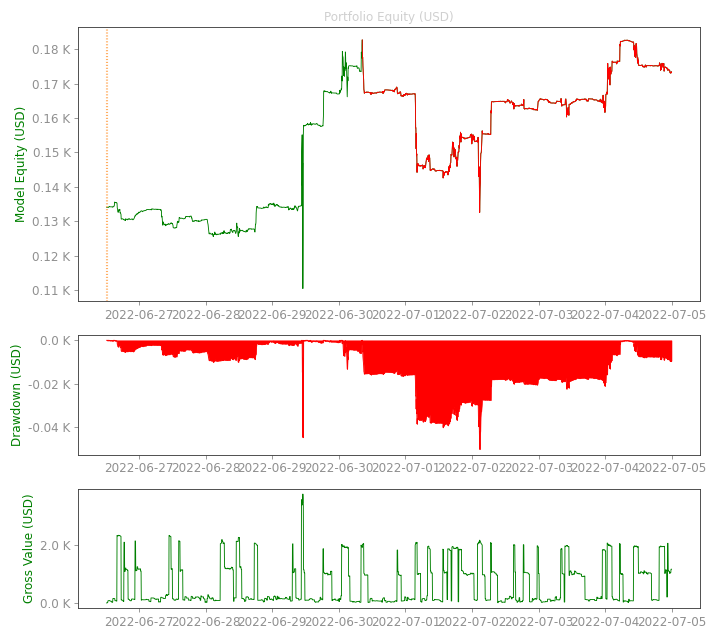

<Figure size 720x640 with 0 Axes>

In [150]:
tearsheet(rs.results[0], 2 * len(c_sigs.columns), insample=str(end_of_train))

<hr/>

We can see that in general this approach may lead to proitable portfolio. Of course there are some things need to verify and check:

 1. Run this on larger amount of data
 2. Best timeframe (may be 15 min or 1h would generate more stable equity curve)
 3. Run co-integrating pairs selection on rolling basis period. Let's say we could use recent N bars for spotting cointegrating pairs.
 4. Regression on log returns series instead of raw prices.